# 房价预测项目

项目背景： 依据给定房子的相关信息对房价进行预测。数据包含一个训练集和一个测试集，训练集数据包括房屋面积、地下室面积、栅栏壁炉、建造时间等房屋信息。

项目流程：

1.  数据探索：查看缺失值、异常值，对数据间的相关性进行分析；
2.  数据处理：删除部分缺失严重字段、异常值，填充部分字段缺失值，检测并调整数据分布；
3.  特征工程：设计特征，对特征数据编码（特征预处理），筛选特征；
4.  建模预测：采用L2正则的线性回归模型获取结果。

In [1]:
# 调用python包
import numpy as np
import pandas as pd    
%matplotlib inline
import matplotlib.pyplot as plt #matlab格式的画图风格
import seaborn as sns 
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings 
def ignore_warn(*args,**kwargs):
    pass
warnings.warn = ignore_warn 
from scipy import stats 
from scipy.stats import norm,skew

In [2]:
# 读取数据
f11 = open('D:/kaggle比赛/房价预测/train.csv')
f12 = open('D:/kaggle比赛/房价预测/test.csv')
train = pd.read_csv(f11)
test = pd.read_csv(f12)

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# 去掉与模型预测无关的Id列
train_ID = train['Id']
test_ID = test['Id']
train.drop('Id',axis = 1,inplace = True)
test.drop('Id',axis = 1,inplace = True)
print('train data size is :{0}'.format(train.shape))
print('test data size is :{0}'.format(test.shape))

train data size is :(1460, 80)
test data size is :(1459, 79)


1. 数据探索

In [7]:
#合并train test数据一起处理
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [8]:
# 查看缺失值
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100 #all_data.isnull().sum()  求出每一列非NaN值的数目，len(all_data)求得行数
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)[:30]  #取排名前30行
missing_data = pd.DataFrame({'missing_ratio':all_data_na})
missing_data.head(10)

,missing_ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


Text(0.5,1,'Percent missing data by feature')

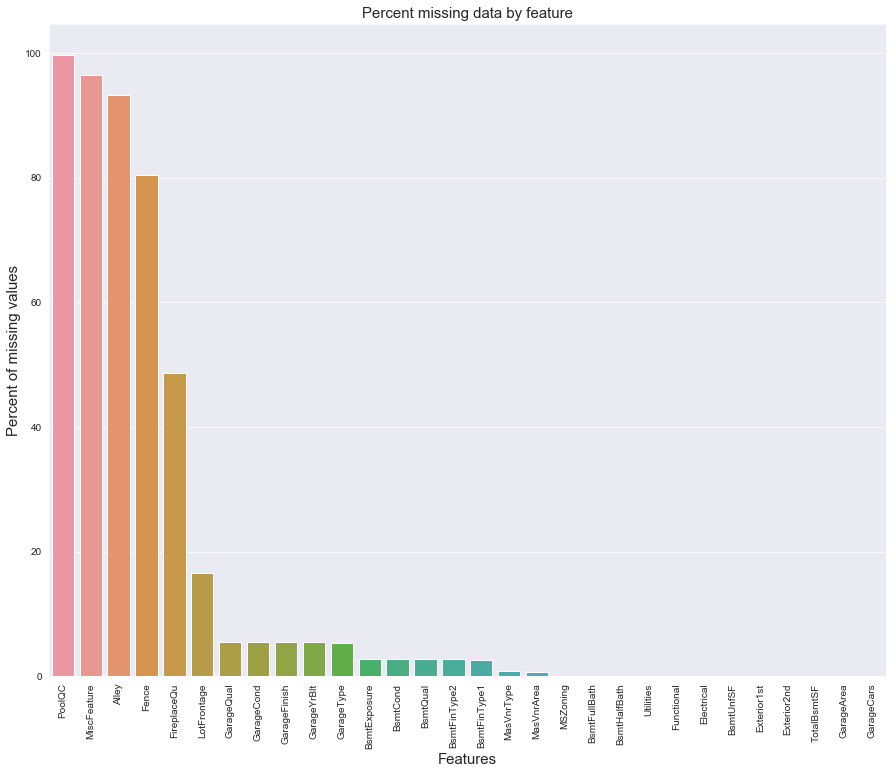

In [9]:
#图表表示缺失度
fig,ax = plt.subplots(figsize = (15,12))
plt.xticks(rotation = '90')
sns.barplot(x = all_data_na.index,y = all_data_na)
plt.xlabel('Features',fontsize = 15)
plt.ylabel('Percent of missing values',fontsize = 15)
plt.title('Percent missing data by feature', fontsize=15)

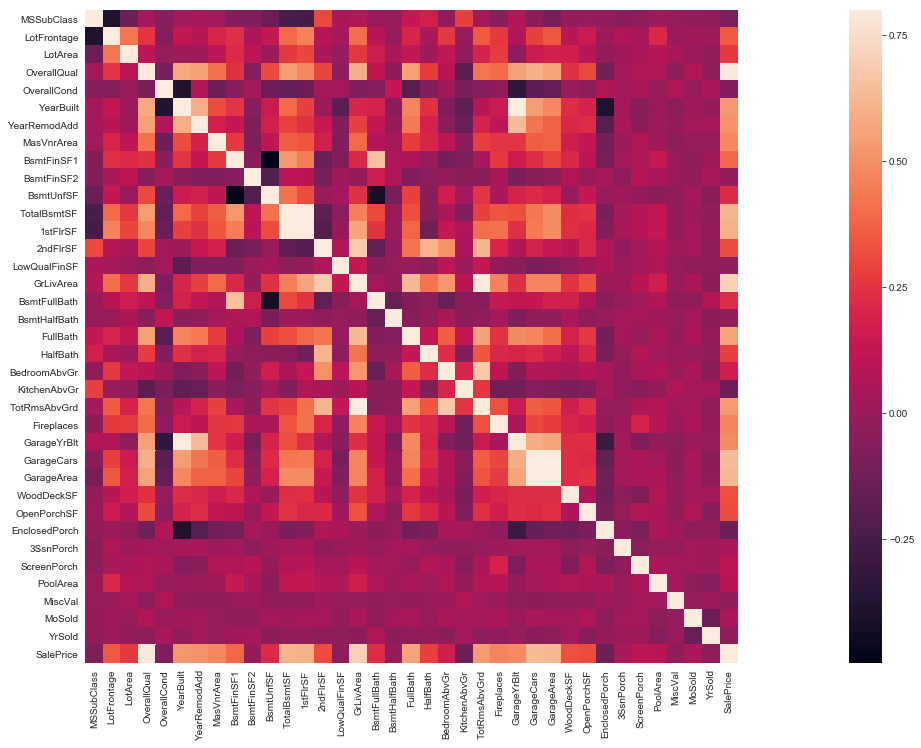

In [16]:
# 绘制热力图查看相关性       更改热力图的大小，看看横坐标数目会不会变多？
corrmat = train.corr()
fig,ax = plt.subplots(figsize = (40,12))
sns.heatmap(corrmat,vmax = .8,square = True) 

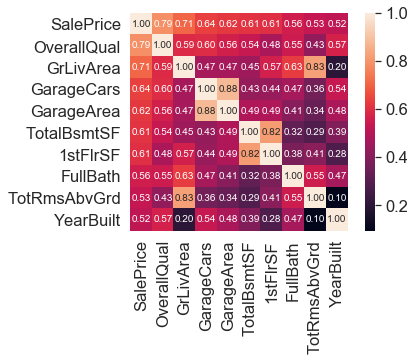

In [18]:
#选出10个与房价相关性最强的属性
k = 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)  #序列自交，行与行进行匹配计算
sns.set(font_scale = 1.5)
sns.heatmap(cm,cbar = True,annot = True,square = True,fmt = '.2f',annot_kws={'size':10},yticklabels = cols.values,xticklabels = cols.values)

Text(0,0.5,'SalePrice')

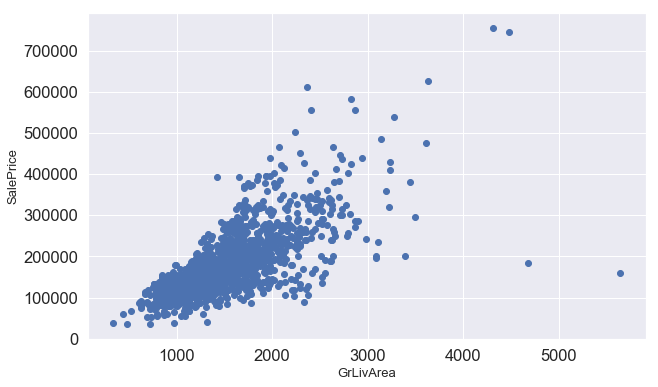

In [19]:
# 发现强相关变量就开始重点关注，将变量与目标进行绘图，找出离散值
# GrLivArea代表含义是居住面积,在图形右下侧有两个异常值，可以考虑删掉
fig,ax = plt.subplots(figsize = (10,6))
ax.scatter(x = train['GrLivArea'],y = train['SalePrice'])
plt.xlabel('GrLivArea',fontsize = 13)
plt.ylabel('SalePrice',fontsize = 13)

Text(0,0.5,'SalePrice')

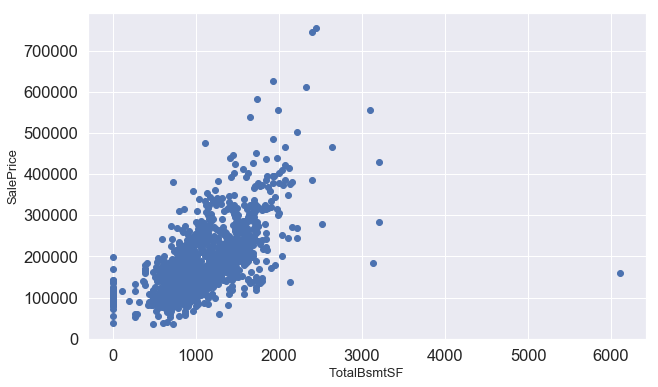

In [20]:
# TotalBsmtSF含义为地下室面积，在右侧似乎也有一个异常值存在
fig,ax = plt.subplots(figsize = (10,6))
ax.scatter(x = train['TotalBsmtSF'],y = train['SalePrice'])
plt.xlabel('TotalBsmtSF',fontsize = 13)
plt.ylabel('SalePrice',fontsize = 13)

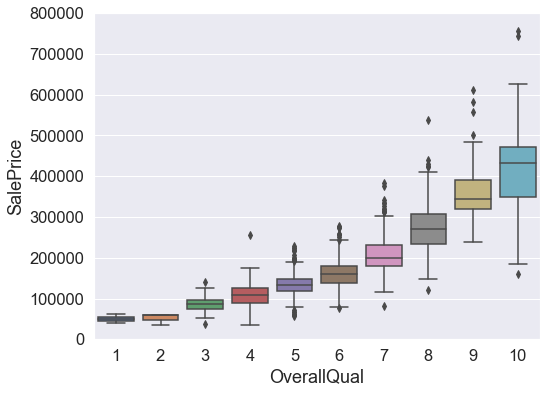

In [21]:
# 房屋质量和房价之间的关系，可以看到随着房屋整体质量的变好，房屋的整体价格也在逐渐提高
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

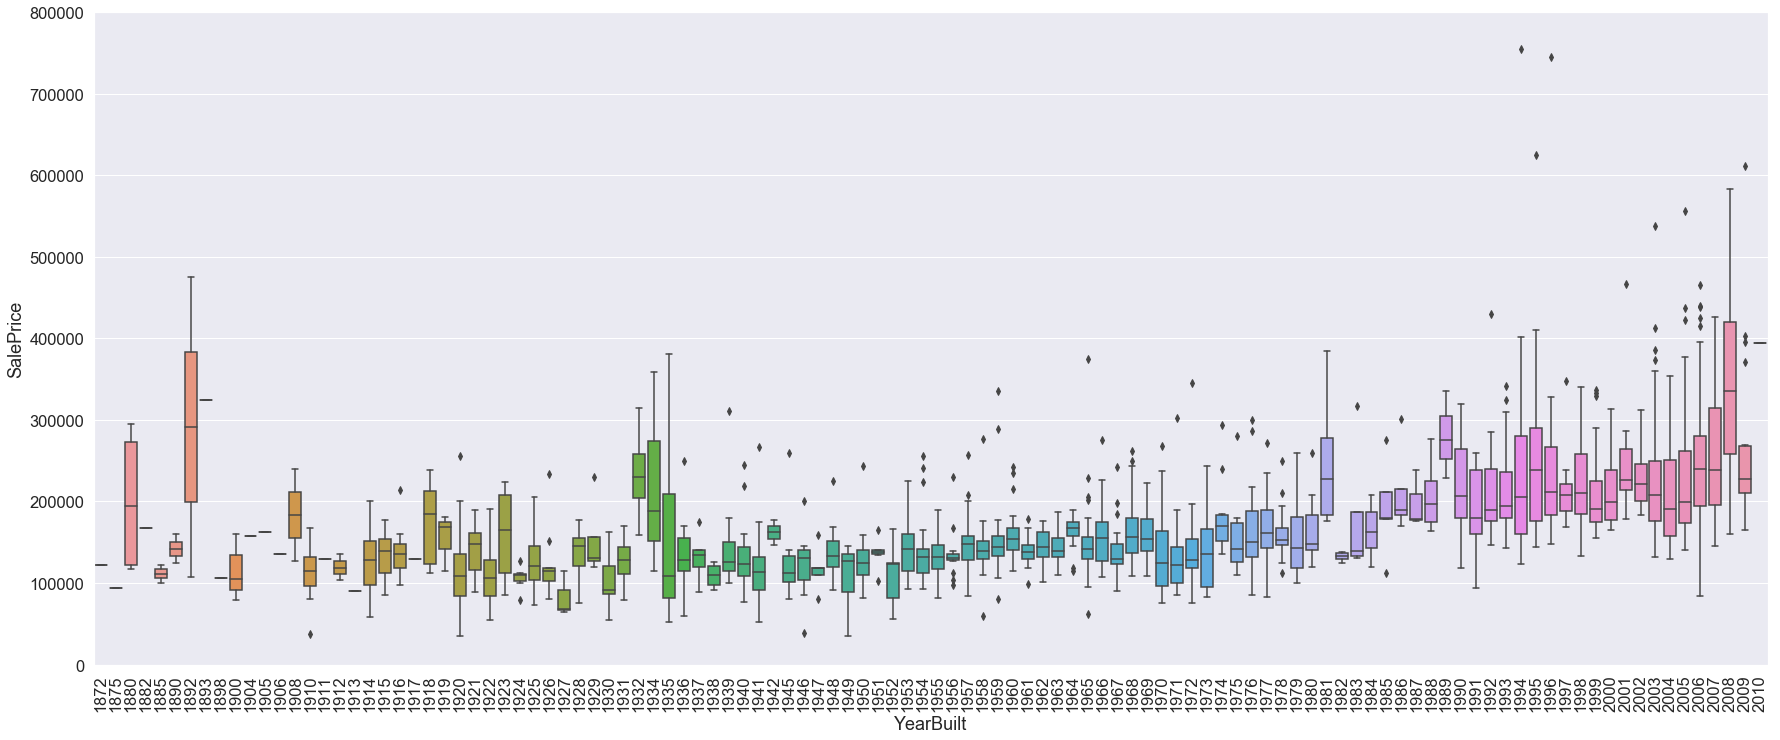

In [23]:
#房屋的建造时间和价格的关系，采用箱型图进行表示，最近建造的新房屋，整体的价格会比较高
xv = 'YearBuilt'
yv = 'SalePrice'
data = pd.concat((train[xv],train[yv]),axis = 1)
fig,ax = plt.subplots(figsize = (30,12))
f = sns.boxplot(x = xv,y = yv,data = data)
f.axis(ymin = 0,ymax = 800000)
plt.xticks(rotation = '90')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

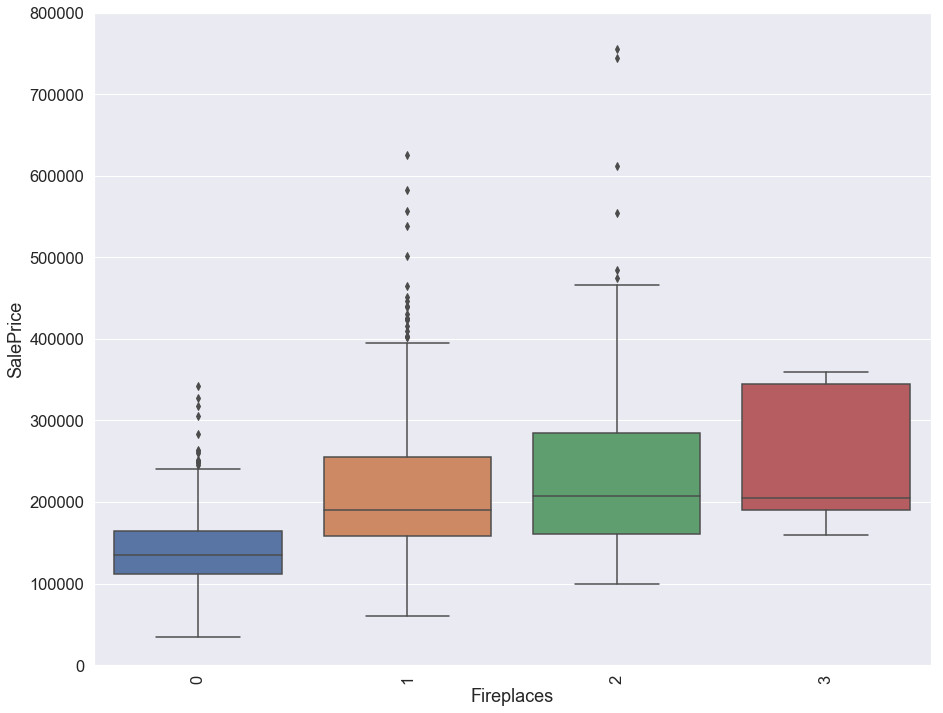

In [24]:
#壁炉数量和房价的关系,壁炉越多，房价越高
xc = 'Fireplaces'
yc = 'SalePrice'
data = pd.concat((train[xc],train[yc]),axis = 1)
fig,ax = plt.subplots(figsize = (15,12))
f = sns.boxplot(x = xc,y = yc,data = data)
f.axis (ymin = 0,ymax = 800000)
plt.xticks(rotation = '90')

2.数据处理

Text(0,0.5,'SalePrice')

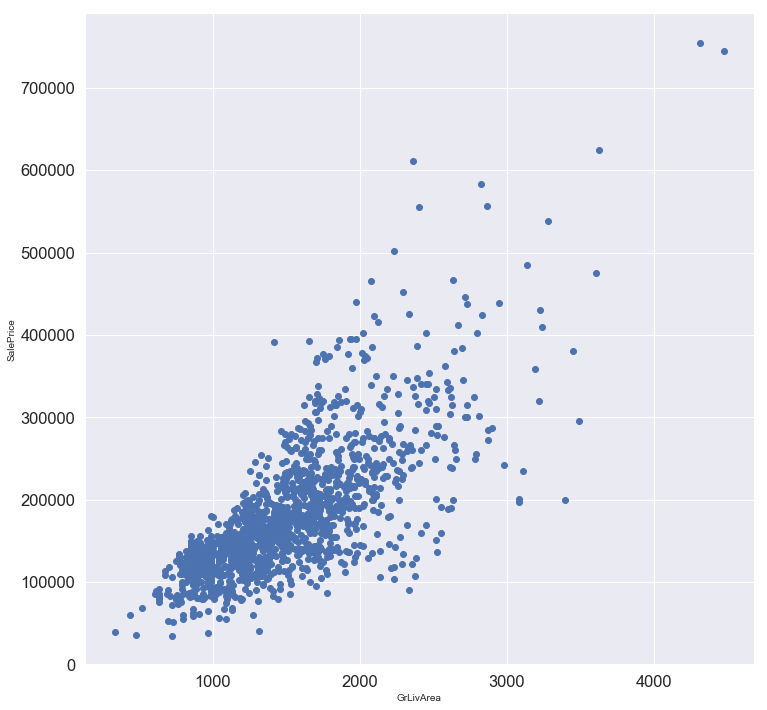

In [27]:
#删除居住面积的异常值，并重新绘制
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice'] < 300000)].index) 
fig,ax = plt.subplots(figsize = (12,12))
ax.scatter(x = train['GrLivArea'],y = train['SalePrice'])
plt.xlabel('GrLivArea',fontsize = 10)
plt.ylabel('SalePrice',fontsize = 10)

Text(0.5,0,'TotalBsmtSF')

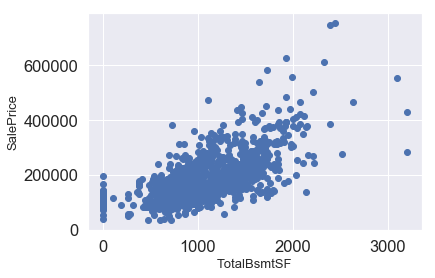

In [26]:
#对于地下室面积，做同样处理
train = train.drop(train[(train['TotalBsmtSF']>5000) & (train['SalePrice']<200000)].index)
fig, ax = plt.subplots()
ax.scatter(train['TotalBsmtSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)

In [28]:
# 删除缺失率在90%以上的数据
all_data = all_data.drop('PoolQC',axis = 1)
all_data = all_data.drop('MiscFeature',axis = 1)
all_data = all_data.drop('Alley',axis = 1)

In [29]:
#对缺失值进行填充
#Fence栅栏，FireplaceQu壁炉，如果数据缺失(NaN)的话可能代表房屋没有栅栏或壁炉，用None填补缺失值，代表没有
all_data['Fence'] = all_data['Fence'].fillna('None')
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

#LotFrontage代表房屋前街道的长度，同一个街区前房屋前街道长度相同，所以用街区的街道长度平均值填充归属对应街区的房屋前街道长度的缺失值
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

#Garage相关的车库变量，注意到这些变量的缺失比例是完全相同的，缺失这些变量的房屋可能是没有车库，用None补充
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

#同样考虑下列变量缺失值的原因可能是因为房屋没有车库，对于连续型变量用0填充
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

#地下室相关连续变量，缺失同样认为房屋可能是没有地下室，用0填充
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
#地下室相关离散变量，房屋没有地下室同理用None填充
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
#Mas为砖石结构相关变量，缺失值我们同样认为是没有砖石结构，用0和none填补缺失值
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)



In [30]:
#MSZoning代表房屋所处的用地类型，看一下不同类型的取值个数
all_data.groupby('MSZoning')['MasVnrArea'].count().reset_index()

,MSZoning,MasVnrArea
0,C (all),25
1,FV,139
2,RH,26
3,RL,2265
4,RM,460


In [31]:
# 对于房屋的用地类型可以考虑用众数进行缺失值的填充
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [32]:
# 同理对其他变量的处理
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
all_data = all_data.drop(['Utilities'], axis=1)

In [33]:
#再看一遍有没有缺失值
all_data_ratio = (all_data.isnull().sum() / len(all_data) ) * 100
all_data_ratio = all_data_ratio.drop(all_data_ratio[all_data_ratio == 0].index).sort_values(ascending = False)
missd = pd.DataFrame({'Missing': all_data_ratio})
print(missd)

Empty DataFrame
Columns: [Missing]
Index: []


C:\Users\tt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180932.92 and sigma = 79467.79



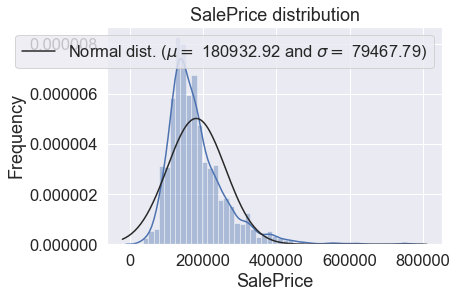

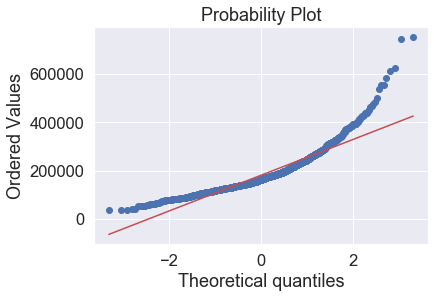

In [34]:
# 检查因变量是否符合正态分布
#采用直方图和qq-plot对房价的分布进行检测，房价的分布是右偏的，需要对其做一些转换让它符合正态分布
sns.distplot(train['SalePrice'],fit = norm) 
#绘制直方图，模拟的黑色线条为正态分布
(mu,sigma) = norm.fit(train['SalePrice']) #计算均值和标准差
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu = $ {:.2f} and $\sigma = $ {:.2f})'
            .format(mu,sigma)],loc = 'best') # loc表示图标位置
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#绘制Q-Q图
fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot= plt)

C:\Users\tt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 12.02 and sigma = 0.40



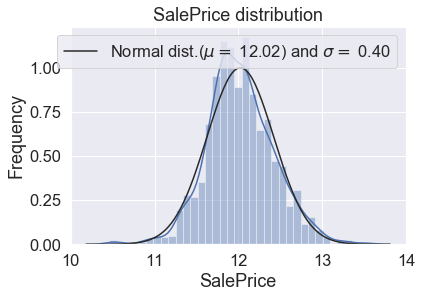

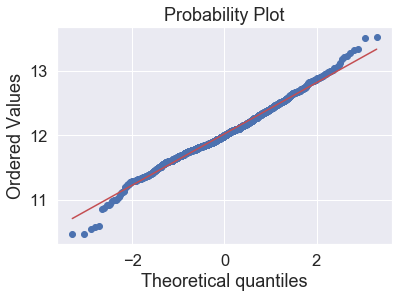

In [35]:
# 下面采用log对数变换对房价进行处理，房价转换后符合正态分布。
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'],fit = norm)

(mu,sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))

plt.legend(['Normal dist.($\mu=$ {:.2f}) and $\sigma=$ {:.2f}'
            .format(mu,sigma)],loc = 0)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot = plt)

3.特征工程

Text(0.5,0,'TotalSF')

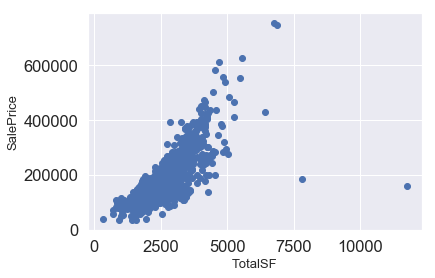

In [36]:
# 下面开始进行特征工程，首先尝试创造一些新特征
#将地下室面积、1楼面积、2楼面积加起来可以得到房屋总面积特征
all_data['TotalSF'] = all_data['TotalBsmtSF'] +  all_data['1stFlrSF'] + all_data['2ndFlrSF'] 
#可视化时候观察到，建造时间比较近的房屋 房价较高，因此将房屋在1990年后建的设置为1，之前为0
all_data['YearBuilt_cut'] = all_data['YearBuilt'].apply(lambda x:1 if x>1990 else 0)
tep = all_data[:ntrain]  #获得不包含SalePrice的train的数据
tep['SalePrice'] = y_train
fig,ax = plt.subplots()
ax.scatter(tep['TotalSF'],tep['SalePrice'])
plt.ylabel('SalePrice',fontsize = 13)
plt.xlabel('TotalSF',fontsize = 13)


发现房屋总面积和房价具有强的线性关系，注意到上述房屋总面积和房价的散点图中有几个异常值可以考虑将其删除。

(array([0, 1]), <a list of 2 Text xticklabel objects>)

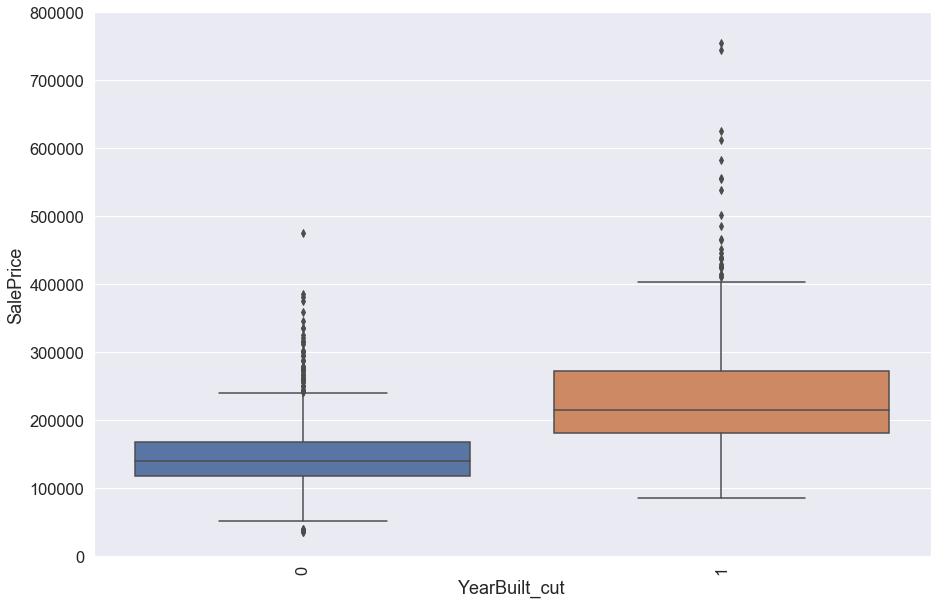

In [37]:
#查看建筑年限和房价的关系 采用箱型图
f,ax = plt.subplots(figsize = (15,10))
fig = sns.boxplot(x = tep['YearBuilt_cut'],y = tep['SalePrice'])
fig.axis(ymin = 0,ymax = 800000)
plt.xticks(rotation = '90')

从上述箱型图可以看出不同建筑年限的房价差异还是比较明显的。

In [38]:
# 开展特征处理， 针对离散性变量进行编码处理，
# 有序性数据用Label Encode
from sklearn.preprocessing import LabelEncoder 
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))
print('all_data size is {}'.format(all_data.shape))
all_data.head()

all_data size is (2919, 77)


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF,YearBuilt_cut
0,856,854,0,3,1Fam,4,3,706.0,0.0,2,...,0,1,8,856.0,0,2003,2003,2,2566.0,1
1,1262,0,0,3,1Fam,4,1,978.0,0.0,0,...,0,1,6,1262.0,298,1976,1976,1,2524.0,0
2,920,866,0,3,1Fam,4,2,486.0,0.0,2,...,0,1,6,920.0,0,2001,2002,2,2706.0,1
3,961,756,0,3,1Fam,1,3,216.0,0.0,0,...,0,1,7,756.0,0,1915,1970,0,2473.0,0
4,1145,1053,0,4,1Fam,4,0,655.0,0.0,2,...,0,1,9,1145.0,192,2000,2000,2,3343.0,1


In [39]:
#对于离散性数据中的非有序性数据按照独热编码进行编译
all_data = pd.get_dummies(all_data)
all_data.shape

(2919, 219)

In [40]:
# 下面进行特征筛选，为避免多重共线性问题，会识别皮尔逊相关系数 大于0.9的特征，并将特征删除。
threshold = 0.9
#建立相关性矩阵
corr_matrix = all_data.corr().abs()
corr_matrix.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
1stFlrSF,1.000000,0.249823,0.044086,0.108418,0.040297,0.247172,0.458206,0.084389,0.123944,0.024482,...,0.214149,0.005882,0.012406,0.000927,0.025617,0.001209,0.044160,0.214337,0.004251,0.163083
2ndFlrSF,0.249823,1.000000,0.032458,0.503506,0.016495,0.114369,0.161997,0.097654,0.158381,0.103646,...,0.012387,0.064275,0.004195,0.006715,0.030842,0.003710,0.003793,0.016457,0.038489,0.034428
3SsnPorch,0.044086,0.032458,1.000000,0.048279,0.004530,0.007307,0.050934,0.023268,0.048451,0.000965,...,0.026513,0.000832,0.006639,0.004280,0.009796,0.005747,0.005417,0.027589,0.005066,0.014798
BedroomAbvGr,0.108418,0.503506,0.048279,1.000000,0.003379,0.116382,0.113161,0.031111,0.105416,0.047212,...,0.050701,0.014303,0.004409,0.033248,0.037084,0.039499,0.022958,0.043436,0.033877,0.047671
BsmtCond,0.040297,0.016495,0.004530,0.003379,1.000000,0.103767,0.095140,0.003905,0.067643,0.072690,...,0.003567,0.015790,0.011458,0.013816,0.065433,0.006755,0.036183,0.006224,0.016353,0.025648


In [41]:
#矩阵是对称的，因此只选择矩阵的上半部分
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
upper.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
1stFlrSF,NaN,0.249823,0.044086,0.108418,0.040297,0.247172,0.458206,0.084389,0.123944,0.024482,...,0.214149,0.005882,0.012406,0.000927,0.025617,0.001209,0.044160,0.214337,0.004251,0.163083
2ndFlrSF,NaN,NaN,0.032458,0.503506,0.016495,0.114369,0.161997,0.097654,0.158381,0.103646,...,0.012387,0.064275,0.004195,0.006715,0.030842,0.003710,0.003793,0.016457,0.038489,0.034428
3SsnPorch,NaN,NaN,NaN,0.048279,0.004530,0.007307,0.050934,0.023268,0.048451,0.000965,...,0.026513,0.000832,0.006639,0.004280,0.009796,0.005747,0.005417,0.027589,0.005066,0.014798
BedroomAbvGr,NaN,NaN,NaN,NaN,0.003379,0.116382,0.113161,0.031111,0.105416,0.047212,...,0.050701,0.014303,0.004409,0.033248,0.037084,0.039499,0.022958,0.043436,0.033877,0.047671
BsmtCond,NaN,NaN,NaN,NaN,NaN,0.103767,0.095140,0.003905,0.067643,0.072690,...,0.003567,0.015790,0.011458,0.013816,0.065433,0.006755,0.036183,0.006224,0.016353,0.025648


In [42]:
#找出不满足条件的特征值
to_drop = [c for c in upper.columns if any(upper[c] > threshold)]
print('%d columns to remove.' %(len(to_drop)))

6 columns to remove.


In [43]:
all_data = all_data.drop(columns = to_drop)
all_data.shape

(2919, 213)

In [44]:
#再把train和test数据分开进行
train = all_data[:ntrain]
test = all_data[ntrain:]

4. 建模预测

In [45]:
#导入一些所需要的包
from sklearn.linear_model import Ridge,RidgeCV,ElasticNet,LassoCV,LassoLarsCV
from sklearn.model_selection import cross_val_score

Text(0,0.5,'rmse')

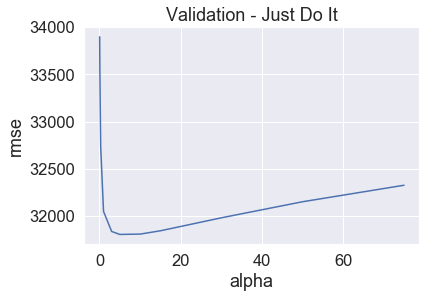

In [46]:
#导入ridge模型
model_ridge = Ridge()
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
# 调参
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [47]:
# alpha参数选择5时用训练集对模型进行训练
clf = Ridge(alpha = 5)  # 实例化Ridge对象
clf.fit(train,y_train)  # 训练Ridge对象

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [50]:
# 最后对测试集进行房价预测
predict = clf.predict(test)
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = predict
sub.to_csv('D:/kaggle比赛/房价预测/submission.csv',index=False)